# Ejercicio de Regresión 1 (Core)

Objetivo

 Aplicar los conceptos de regresión lineal para resolver un problema práctico utilizando Python.

 Descripción del problema: Supongamos que trabajas en una empresa que desea predecir el precio de venta de casas en función de varias características. Tienes un conjunto de datos con información sobre las casas, incluyendo el tamaño de la casa (en pies cuadrados), el número de habitaciones, el número de baños y la antigüedad de la casa (en años). Tu tarea es construir un modelo de regresión lineal que pueda predecir el precio de venta de una casa dada.

Instrucciones:

1. Carga de datos: Descarga el archivo de datos house_prices.csv que contiene las siguientes columnas:
* SqFt: Tamaño de la casa en pies cuadrados.
* Bedrooms: Número de habitaciones.
* Bathrooms: Número de baños.
* price: Precio de venta de la casa.
2. Exploración de datos: Realiza un análisis exploratorio de los datos para entender su estructura y detectar posibles problemas como valores nulos o outliers.
3. Preparación de datos: Divide los datos en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%).
4. Entrenamiento del modelo: Entrena un modelo de regresión lineal utilizando los datos de entrenamiento.
5. Evaluación del modelo: Evalúa el modelo utilizando el conjunto de prueba. Calcula el error cuadrático medio (MSE) y el R-cuadrado (R²) del modelo.
6. Predicción: Usa el modelo entrenado para predecir el precio de una casa con las siguientes características:
* Tamaño: 2000 pies cuadrados
* Habitaciones: 3
* Baños: 2

### Librerias y Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data=pd.read_csv('../Data/house_prices.csv')

### Consistencia en tipos de datos

Convertimos todas las columnas en sus respectivos dtypes

In [2]:
data_dict = {
    'Home': 'int64',
    'Price': 'float64',
    'SqFt': 'float64',
    'Bedrooms': 'int64',
    'Bathrooms': 'int64',
    'Offers': 'int64',
    'Brick': 'bool',
    'Neighborhood': 'category'
    
}

# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    data[column] = data[column].astype(dtype, errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Home          128 non-null    int64   
 1   Price         128 non-null    float64 
 2   SqFt          128 non-null    float64 
 3   Bedrooms      128 non-null    int64   
 4   Bathrooms     128 non-null    int64   
 5   Offers        128 non-null    int64   
 6   Brick         128 non-null    bool    
 7   Neighborhood  128 non-null    category
dtypes: bool(1), category(1), float64(2), int64(4)
memory usage: 6.5 KB


Identificamos inconsistencias en valores categoricos

In [3]:
# Identificar columnas de tipo 'object', típicamente usadas para variables categóricas
categorical_columns = data.select_dtypes(include=['category','bool']).columns
# Crear un diccionario donde cada clave es el nombre de la columna y los valores son los valores únicos de esa columna
unique_values_dict = {col: data[col].unique() for col in categorical_columns}
# Convertir el diccionario en un DataFrame, rellenando con NaN cuando haya menos valores únicos
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index').transpose()
# Mostrar el DataFrame resultante
unique_values_df.T

,0,1,2
Brick,True,None,None
Neighborhood,East,North,West


### Limpieza de datos

Realizamos histogramas para conocer sus distribuciones de las columnas Price y SqFt que son las variables numericas

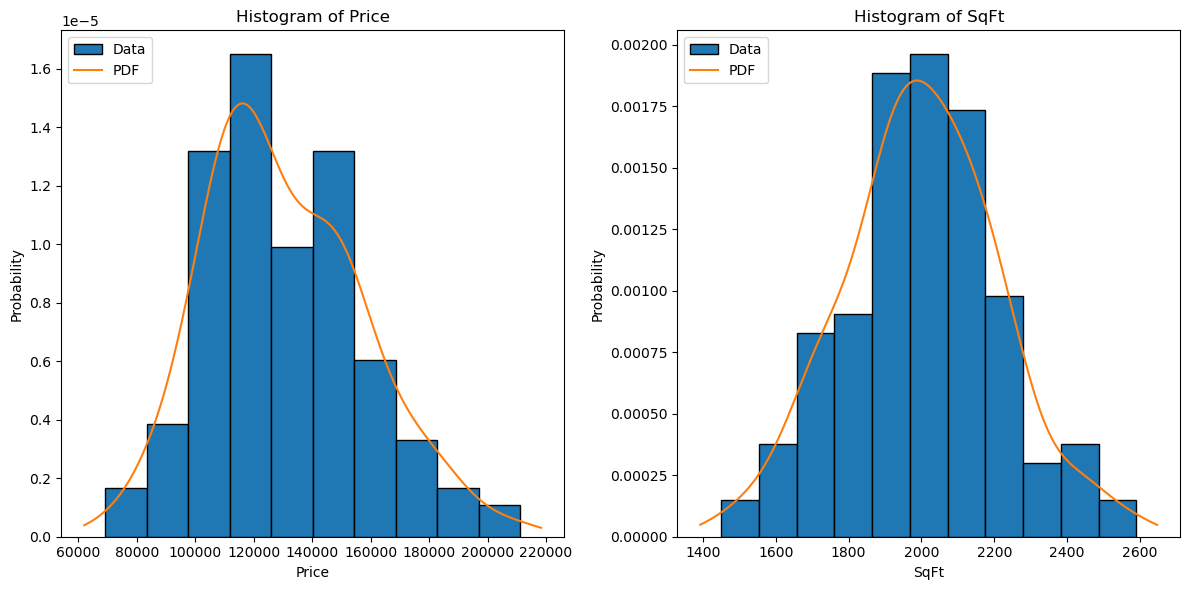

In [4]:
def plot_histogram_kde(data, ax, label):
    # Calcular los bins de Freedman-Diaconis
    q25, q75 = np.percentile(data, [25, 75])
    bin_width = 2 * (q75 - q25) * len(data) ** (-1/3)
    bins = round((data.max() - data.min()) / bin_width)
    
    # Graficar histograma y KDE
    ax.hist(data, density=True, bins=bins, label="Data", edgecolor='black')
    mn, mx = ax.get_xlim()
    kde_xs = np.linspace(mn, mx, 300)
    kde = st.gaussian_kde(data)
    ax.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    ax.set_ylabel("Probability")
    ax.set_xlabel(label)
    ax.set_title(f"Histogram of {label}")
    ax.legend(loc="upper left")

# Crear la figura y los subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráficos para 'Price' y 'SqFt'
plot_histogram_kde(data['Price'], axes[0], 'Price')
plot_histogram_kde(data['SqFt'], axes[1], 'SqFt')

plt.tight_layout()
plt.show()


Creamos boxplots para identificar Outliers

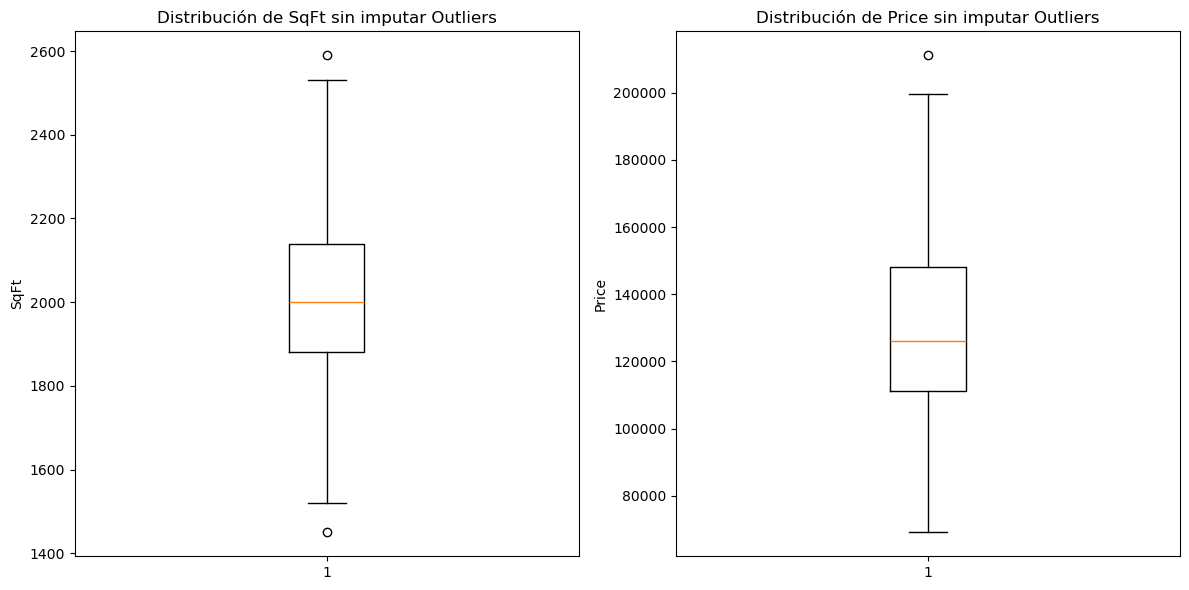

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Primer gráfico: Boxplot de 'SqFt'
axes[0].boxplot(data['SqFt'])
axes[0].set_title('Distribución de SqFt sin imputar Outliers')
axes[0].set_ylabel('SqFt')

# Segundo gráfico: Boxplot de 'Price'
axes[1].boxplot(data['Price'])
axes[1].set_title('Distribución de Price sin imputar Outliers')
axes[1].set_ylabel('Price')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

Calculamos el rango IQR para poder imputar valores Outliers en un nuevo dataframe

In [6]:
cols = ['Price', 'SqFt']  # one or more

Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1

#Creamos un nuevo dataframe para no modificar el original
data_imputed = data.copy()

mean_price = data['Price'].mean()
data_imputed.loc[(data_imputed['Price'] < (Q1['Price'] - 1.5 * IQR['Price'])) | (data_imputed['Price'] > (Q3['Price'] + 1.5 * IQR['Price'])), 'Price'] = int(mean_price)

mean_sqft = data['SqFt'].mean()
data_imputed.loc[(data_imputed['SqFt'] < (Q1['SqFt'] - 1.5 * IQR['SqFt'])) | (data_imputed['SqFt'] > (Q3['SqFt'] + 1.5 * IQR['SqFt'])), 'SqFt'] = int(mean_sqft)


Graficamos histogramas del nuevo dataframe

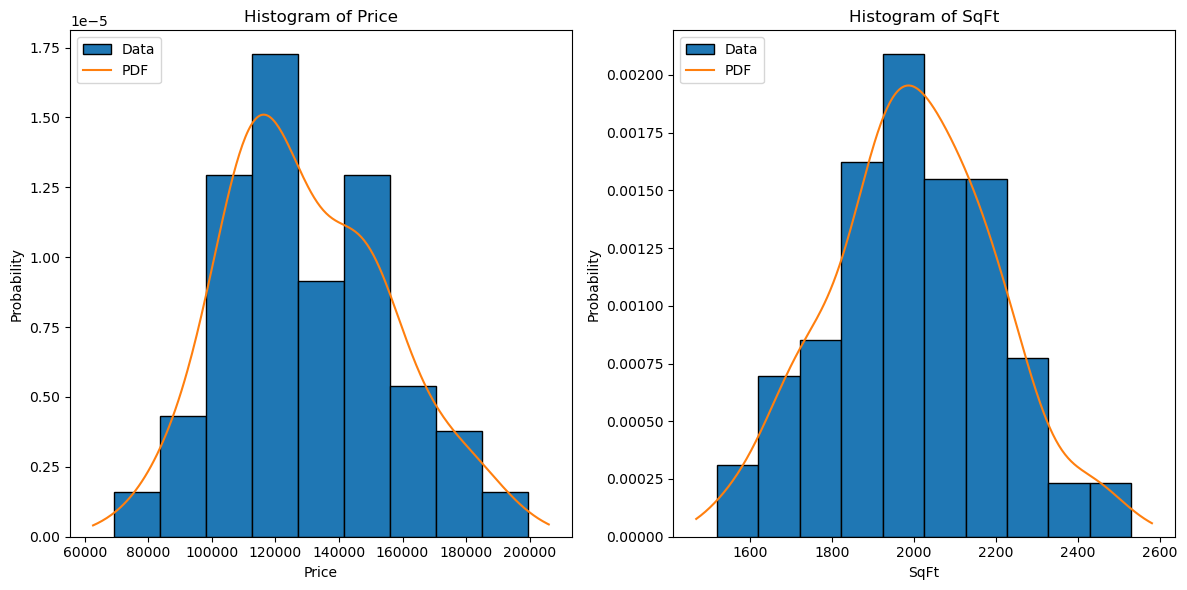

In [7]:
def plot_histogram_kde(data_imputed, ax, label):
    # Calcular los bins de Freedman-Diaconis
    q25, q75 = np.percentile(data_imputed, [25, 75])
    bin_width = 2 * (q75 - q25) * len(data_imputed) ** (-1/3)
    bins = round((data_imputed.max() - data_imputed.min()) / bin_width)
    
    # Graficar histograma y KDE
    ax.hist(data_imputed, density=True, bins=bins, label="Data", edgecolor='black')
    mn, mx = ax.get_xlim()
    kde_xs = np.linspace(mn, mx, 300)
    kde = st.gaussian_kde(data_imputed)
    ax.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    ax.set_ylabel("Probability")
    ax.set_xlabel(label)
    ax.set_title(f"Histogram of {label}")
    ax.legend(loc="upper left")

# Crear la figura y los subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráficos para 'Price' y 'SqFt'
plot_histogram_kde(data_imputed['Price'], axes[0], 'Price')
plot_histogram_kde(data_imputed['SqFt'], axes[1], 'SqFt')

plt.tight_layout()
plt.show()

Vemos los boxplots para poder ver si se eliminaron algunos Outliers

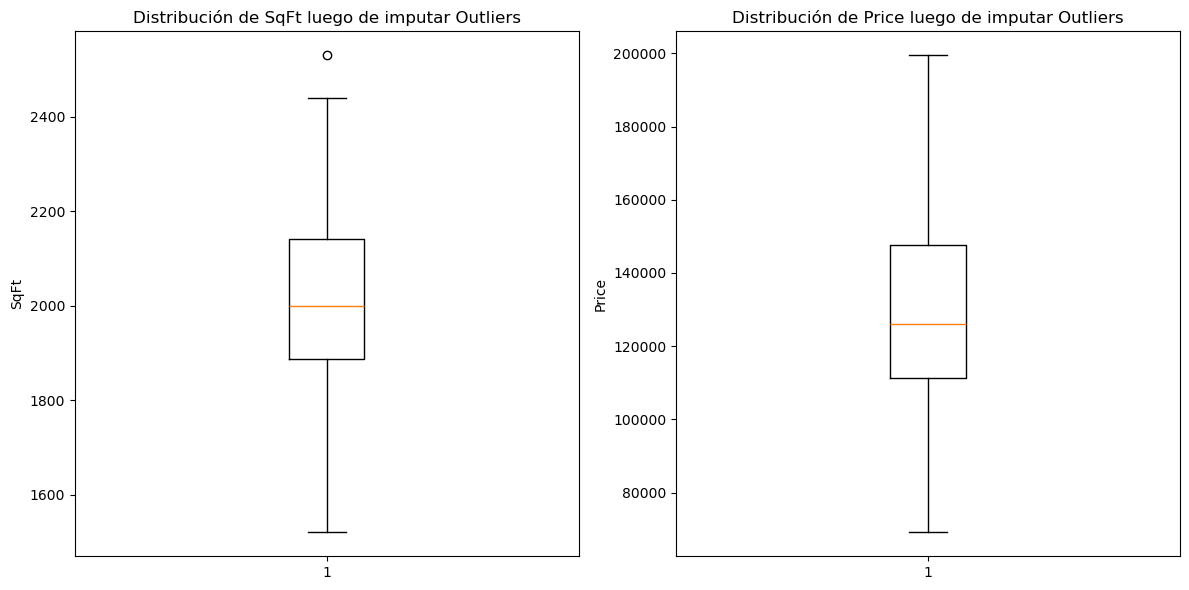

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Primer gráfico: Boxplot de 'SqFt'
axes[0].boxplot(data_imputed['SqFt'])
axes[0].set_title('Distribución de SqFt luego de imputar Outliers')
axes[0].set_ylabel('SqFt')

# Segundo gráfico: Boxplot de 'Price'
axes[1].boxplot(data_imputed['Price'])
axes[1].set_title('Distribución de Price luego de imputar Outliers')
axes[1].set_ylabel('Price')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

### Model

In [9]:
X, y = data_imputed[['SqFt', 'Bedrooms', 'Bathrooms', 'Offers']], data_imputed['Price']  # Características y objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression().fit(X_train, y_train)  # Ajuste del modelo

mse, r2 = mean_squared_error(y_test, model.predict(X_test)), r2_score(y_test, model.predict(X_test))  # Métricas

print(f'Error Cuadrático Medio: {mse}\nR-cuadrado: {r2}')
print('Coeficiente del modelo:', model.coef_, '\nIntercepto del modelo:', model.intercept_)


Error Cuadrático Medio: 213192788.14896426
R-cuadrado: 0.6708148585267473
Coeficiente del modelo: [    44.72003814  10371.13915719  15328.56888902 -12049.64527506] 
Intercepto del modelo: 3270.5967775607132


Hacemos la prediccion para calcular el precio para un nuevo dato

In [10]:
new_data = pd.DataFrame([[2000, 3, 2, 1]], columns=['SqFt', 'Bedrooms', 'Bathrooms', 'Offers'])  # Convertir datos de entrada
prediction = model.predict(new_data)  # Predicción con los nuevos datos

print(f'Predicción del precio: {prediction[0]}')

Predicción del precio: 142431.58303031503
